# 6: STARmap_CLustering

HiSTaR can process STARmap data to extract low-dimension representation. In this tutorial, we use Mouse Visual cortex dataset to introduce the analysis<br>
The raw STARmap mouse visual cortex data can be dowmload https://www.dropbox.com/sh/f7ebheru1lbz91s/AADm6D54GSEFXB1feRy6OSASa/visual_1020/20180505_BY3_1kgenes?dl=0&subfolder_nav_tracking=1<br>
The annotation information comes from STAGATE https://drive.google.com/drive/folders/1I1nxheWlc2RXSdiv24dex3YRaEh780my?usp=sharing.<br>
The complete experimental dataset is available here https://zenodo.org/records/15599070<br>

## Preparation

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import torch
warnings.filterwarnings("ignore")

In [2]:
import HiSTaR
random_seed = 2023
HiSTaR.fix_seed(random_seed)

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
adata = sc.read('../data/STARmap_20180505_BY3_1k.h5ad')

In [4]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)
sc.pp.log1p(adata)
adata = adata[:, adata.var['highly_variable']]
sc.pp.scale(adata)

from sklearn.decomposition import PCA
adata.obsm['X_pca'] = PCA(n_components=200, random_state=42).fit_transform(adata.X)

## Constructing the spatial network

In [5]:
# construct graph
graph_dict = HiSTaR.graph_construction(adata, 12)

In [6]:
adata

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'label_colors', 'hvg', 'log1p'
    obsm: 'spatial', 'X_pca'

## Running HiSTaR

In [7]:
histar_net = HiSTaR.histar(adata.obsm['X_pca'], graph_dict, device=device)
histar_net.train()
histar_feat, _, _, _ = histar_net.process()
adata.obsm['HiSTaR'] = histar_feat

## Clustering

In [8]:
#HiSTaR.configure_r_environment()   # If you encounter problems loading R packages, you can manually configure your path in this function.

In [9]:
HiSTaR.mclust_R(adata, 7, use_rep='HiSTaR', key_added='HiSTaR')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label', 'HiSTaR'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'label_colors', 'hvg', 'log1p'
    obsm: 'spatial', 'X_pca', 'HiSTaR'

### Visualization

<Axes: title={'center': 'HiSTaR'}, xlabel='spatial1', ylabel='spatial2'>

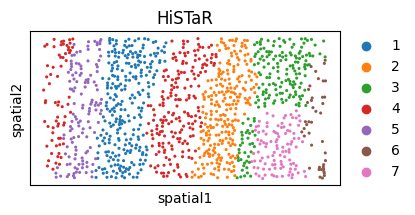

In [10]:
plt.rcParams["figure.figsize"] = (4, 2)
sc.pl.embedding(adata, basis="spatial", color='HiSTaR', s=20, show=False, title=f"HiSTaR",)#, legend_loc=False)

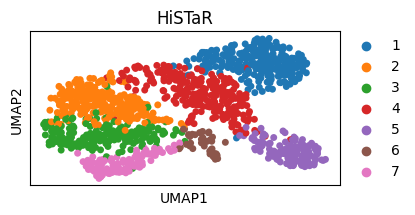

In [11]:
sc.pp.neighbors(adata, use_rep='HiSTaR')
sc.tl.umap(adata)
sc.pl.umap(adata, color='HiSTaR', title=f"HiSTaR",)